In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Uber driver data

This dataset contains 3 months of trips of an Uber driver. The driver works in San Francisco and around the Bay Area.

In [2]:
df = pd.read_csv('sample_sf_user_trip.csv', parse_dates=['pickup_time', 'dropoff_time'])

## Question

Where and when the driver should start a daily driving session to maximize his/her hourly income on any given day of the week? (use the column *payment* as driver's net income per trip)



# Exploratory data analysis (EDA)

Let's check if the driver traveled in the same time zone or area by checking the lat and lon.

In [110]:
print('min lat {}, max lat {}, min lon {}, max lon {}'.format(min(df.pickup_latitude), max(df.pickup_latitude), min(df.pickup_longitude), max(df.pickup_longitude)))

min lat 37.304916051300005, max lat 37.9050444346, min lon -122.51110794, max lon -121.93040415700001


So yes, the driver in this dataset drove within 50 miles, so same timezone. Since timezone is the same, we can just transform the time accordingly. Let's add a sec_of_day column since the duration is already in seconds. Also add a weekday column since weekend and weekdays might be very different. 

Check if commission varies a lot between trips

<ipython-input-5-0d16fb6302bd>:2: RuntimeWarning: invalid value encountered in true_divide
  commission_percent = -df.breakdown_commission.values/df.breakdown_other.values * 100


Text(0.5, 1.0, 'Commission percentage for all drivers')

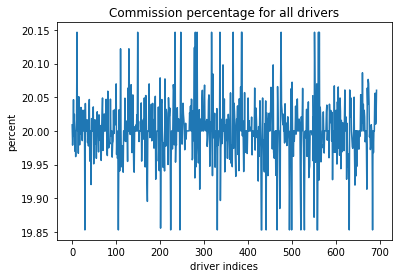

In [5]:
# check commission
commission_percent = -df.breakdown_commission.values/df.breakdown_other.values * 100
plt.plot(commission_percent)
plt.xlabel('driver indices')
plt.ylabel('percent')
plt.title('Commission percentage for all drivers')

In [6]:
# std of commission_percent
np.std(commission_percent[~np.isnan(commission_percent)]) # there's one nan due to division by 0

0.046643931042998736

Commission seems pretty steady at ~20% of the total breakdown, and the standard deviation is merely ~0.05%. Therefore it's reasonable to drop this column and not include in the payment analysis.  

Create extra features for time from the datetime formatting. 

In [4]:
import datetime
sec_of_day = df.pickup_time.apply(lambda x: 60**2*x.time().hour + 60*x.time().minute + x.time().second)
hr_of_day = df.pickup_time.apply(lambda x: x.time().hour)
weekday = df.pickup_time.apply(lambda x: x.weekday())
df.insert(1, 'sec_of_day', sec_of_day, True) # 86400 seconds in a day
df.insert(2, 'weekday', weekday, True) # 0 to 6
df.insert(3, 'hr_of_day', hr_of_day, True)
df.head(10)
#df.drop(columns = 'sec_of_day',inplace=True)
#df.drop(columns = 'hr_of_day',inplace=True)
#df.drop(columns = 'weekday',inplace=True)

,user_id,sec_of_day,weekday,hr_of_day,pickup_time,pickup_latitude,pickup_longitude,dropoff_time,dropoff_latitude,dropoff_longitude,fare,surge_multiplier,distance,duration,payment,breakdown_toll,breakdown_commission,breakdown_other
0,44898,30588,2,8,2017-03-08 08:29:48-08:00,37.745289,-122.440407,2017-03-08 08:49:43-08:00,37.776630,-122.424942,12.50,1.0,3.66,1195,17.79,0.0,-4.45,22.24
1,44898,32290,2,8,2017-03-08 08:58:10-08:00,37.781427,-122.432337,2017-03-08 09:18:26-08:00,37.788528,-122.399144,12.51,1.2,2.22,1216,15.14,0.0,-3.78,18.92
2,44898,35300,2,9,2017-03-08 09:48:20-08:00,37.792355,-122.409302,2017-03-08 10:02:44-08:00,37.795754,-122.446166,10.35,1.0,2.55,864,6.48,0.0,-1.62,8.10
3,44898,36482,2,10,2017-03-08 10:08:02-08:00,37.796379,-122.446989,2017-03-08 10:21:43-08:00,37.803171,-122.402654,11.18,1.0,3.15,821,6.90,0.0,-1.73,8.63
4,44898,37698,2,10,2017-03-08 10:28:18-08:00,37.807661,-122.412922,2017-03-08 11:03:23-08:00,37.617960,-122.386336,17.23,1.0,1.70,2106,22.17,0.0,-5.54,27.71
5,44898,40860,2,11,2017-03-08 11:21:00-08:00,37.775173,-122.401336,2017-03-08 11:35:05-08:00,37.797456,-122.402971,11.08,1.0,2.61,844,6.47,0.0,-1.62,8.09
6,44898,42833,2,11,2017-03-08 11:53:53-08:00,37.790560,-122.413189,2017-03-08 12:05:59-08:00,37.774024,-122.398900,7.92,1.0,1.74,726,5.33,0.0,-1.33,6.66
7,44898,32414,4,9,2017-03-10 09:00:14-08:00,37.752521,-122.425156,2017-03-10 09:27:32-08:00,37.805169,-122.405279,17.19,1.0,5.12,1638,22.24,0.0,-5.56,27.80
8,44898,34763,4,9,2017-03-10 09:39:23-08:00,37.792264,-122.410906,2017-03-10 09:59:07-08:00,37.757815,-122.390346,12.11,1.0,3.60,1185,8.38,0.0,-2.09,10.47
9,44898,36557,4,10,2017-03-10 10:09:17-08:00,37.776354,-122.397489,2017-03-10 10:13:53-08:00,37.769369,-122.406570,6.60,1.0,1.04,276,4.00,0.0,-1.00,5.00


Let's see correlations between variables (colinearity), so we can get a sense of variables we need to consider, e.g., if pickup and dropoff locations are correlated/closeby, then we can just use one or the other. 

In [109]:
df.corr() # no nans in the table, user_id is a constant, therefore it's NaN here

,user_id,sec_of_day,weekday,hr_of_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare,surge_multiplier,distance,duration,payment,breakdown_toll,breakdown_commission,breakdown_other
user_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sec_of_day,NaN,1.000000,-0.076332,0.998094,0.075911,-0.028056,0.121221,-0.132845,-0.020170,-0.079260,-0.063022,-0.015494,-0.057771,-0.029362,0.056421,-0.056384
weekday,NaN,-0.076332,1.000000,-0.076185,-0.015848,-0.054638,-0.065372,-0.025062,0.027446,0.014508,0.099025,0.010673,0.019501,-0.036813,-0.025391,0.025411
hr_of_day,NaN,0.998094,-0.076185,1.000000,0.071250,-0.026590,0.118967,-0.128024,-0.018268,-0.085154,-0.060576,-0.013743,-0.056123,-0.028396,0.054821,-0.054791
pickup_latitude,NaN,0.075911,-0.015848,0.071250,1.000000,-0.459742,0.493752,-0.324746,-0.219649,0.056775,-0.264668,-0.079549,-0.149532,0.027643,0.159988,-0.160065
pickup_longitude,NaN,-0.028056,-0.054638,-0.026590,-0.459742,1.000000,-0.269572,0.483631,0.155544,-0.028242,0.167110,0.017300,0.123475,0.041289,-0.123403,0.123420
dropoff_latitude,NaN,0.121221,-0.065372,0.118967,0.493752,-0.269572,1.000000,-0.459159,-0.523699,0.058517,-0.581371,-0.251660,-0.464611,0.016063,0.487830,-0.487848
dropoff_longitude,NaN,-0.132845,-0.025062,-0.128024,-0.324746,0.483631,-0.459159,1.000000,0.487002,-0.028966,0.524143,0.268020,0.454186,0.245779,-0.441139,0.441159
fare,NaN,-0.020170,0.027446,-0.018268,-0.219649,0.155544,-0.523699,0.487002,1.000000,0.039930,0.856475,0.558527,0.873996,0.335879,-0.867704,0.867680
surge_multiplier,NaN,-0.079260,0.014508,-0.085154,0.056775,-0.028242,0.058517,-0.028966,0.039930,1.000000,-0.063119,0.035574,0.103497,-0.013713,-0.109935,0.110035


The correlation between pickup and dropoff latitudes and longitudes shows weak correlation at \~0.5. Therefore we'll need to include both sets of variables in our further analysis. 

The correlation between payment and dropoff locations shows a stronger correlation (\~0.5) than payment and pickup locations (\~0.13). This might be that people are paying certain prices to get to a specific location, and starting from random locations. 

Interestingly the latitude is negatively correlated to the payment, which might be people travelling south (we'll confirm this later in the spatial recommendation).

The correlation is high (0.87) between payment and distance, therefore we can almost directly conclude that the higher payments are mostly due to longer distance. And some higher payments may be associated to time of day.

# Temporal recommendation
Since hr_of_day intuitively have some kind of relationship (maybe nonlinear) to payment. Therefore let's just make a x-y plot of hour of day vs payment. 


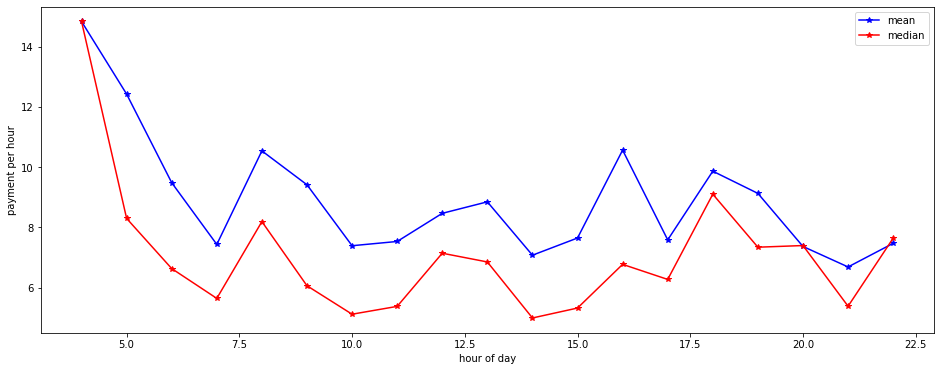

<AxesSubplot:xlabel='hr_of_day', ylabel='payment'>

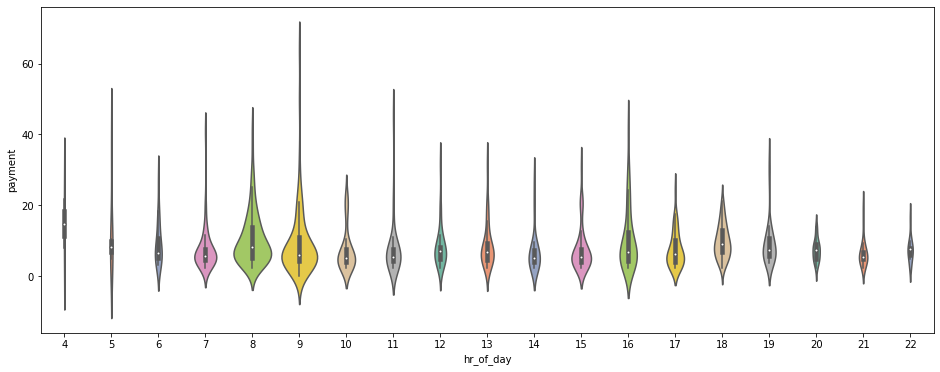

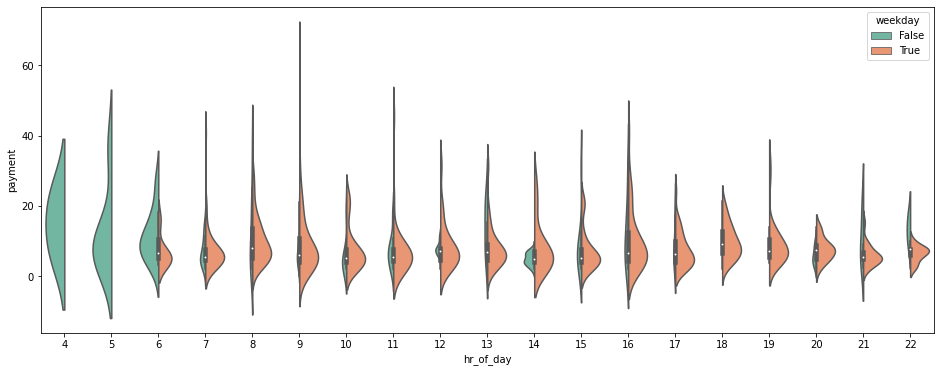

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(df[['payment','hr_of_day']].groupby('hr_of_day').mean(),'b*-')
plt.plot(df[['payment','hr_of_day']].groupby('hr_of_day').median(),'r*-')
plt.ylabel('payment per hour')
plt.xlabel('hour of day')
plt.legend(['mean','median'])
plt.show()
plt.figure(figsize=(16, 6))
import seaborn as sns
tmp = pd.concat([df[['payment','hr_of_day']], df['weekday']<=4], axis=1)
sns.violinplot(x="hr_of_day", y="payment", 
               data = tmp, palette="Set2", split=True, scale="count")
plt.figure(figsize=(16, 6))
sns.violinplot(x="hr_of_day", y="payment", hue="weekday",
               data = tmp, palette="Set2", split=True, scale="count", scale_hue=True)

At first the mean payment (fig 1) seems to favor midnight (4-6am), but a closer look at the  violinplot (fig 3) with two hues (weekend, weekday) scaled independently shows that the 4-6am price surge are weekend drives. The violinplot (fig 2) independent of days shows that the 4-6am drives are miniscule in volume. 

Therefore if the driver wants to driving during the weekend, just wake up early at 4am and work until 6am. 

The violinplot (fig 2) shows that there are much more customers in the morning rush hours (7-9am). The afternoon rush hours (16-18pm) have the similar mean and median but less volumes compared to the morning rush hours. This can be understood by morning needing punctuality to work, but afternoon going home need not (so train might be good enough). Therefore 7-9am and 16-18pm are both good times, but morning is more preferred. 



# Spatial recommendation
Next check the spatial distribution of payments

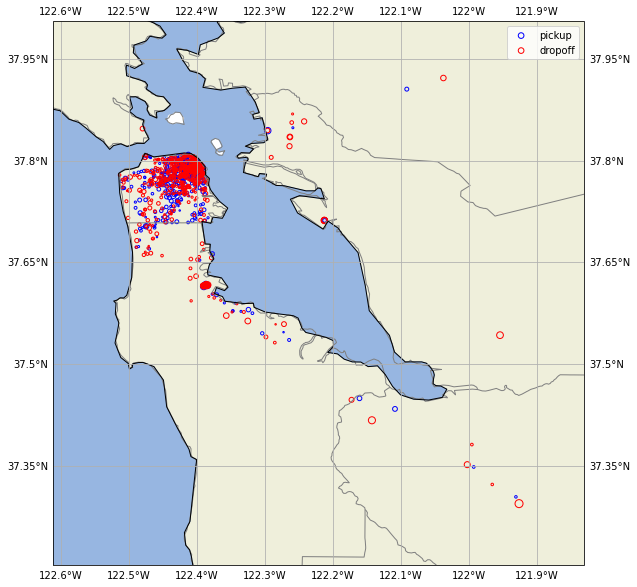

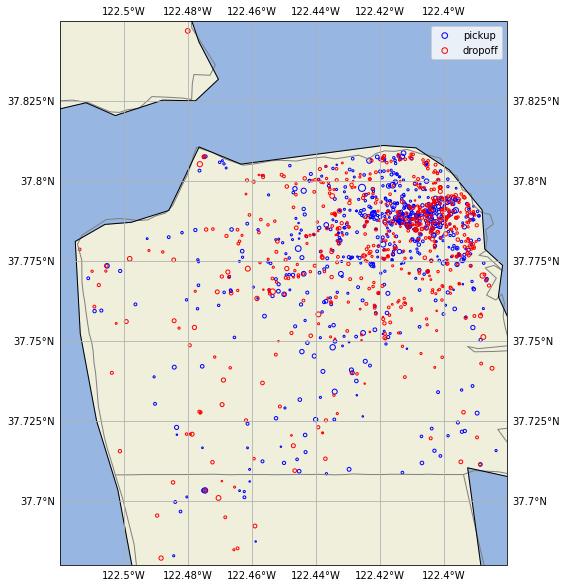

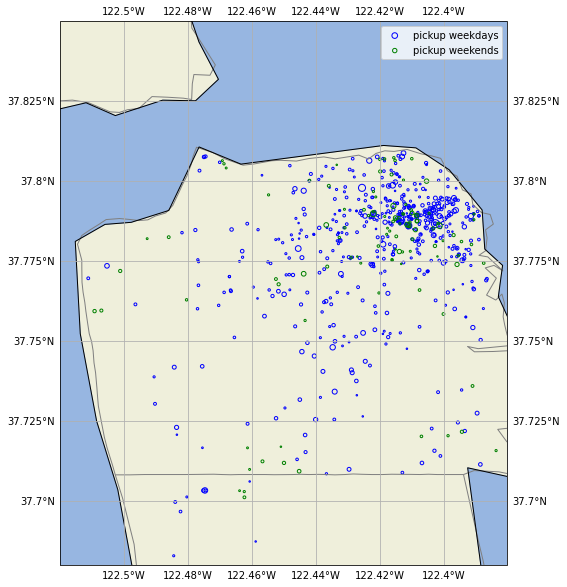

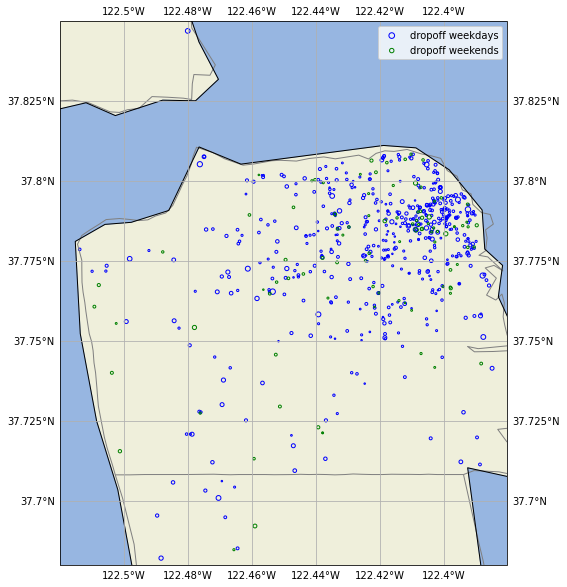

In [105]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
# data for plotting location and the scale of payments
x = [df['pickup_longitude'], df['dropoff_longitude']]
y = [df['pickup_latitude'], df['dropoff_latitude']]
s = df['payment'] # the scale of the scatter dots is proportional to the payment

fig1 = plt.figure(figsize=(10, 10))
extent = (minlon-.1, maxlon+.1, minlat-.1, maxlat+.1)
ax = plt.axes(projection=ccrs.PlateCarree())

# plot county boundaries
reader = shpreader.Reader('countyl010g.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

# plot ocean, land, lakes
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.add_feature(cfeature.OCEAN.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

# plot coastline and lat-lon gridlines
gl = ax.gridlines(draw_labels=True)
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.set_extent(extent)

# plot entire SF bay area pickup dropoff locations 
# with the scale of the circle representing payment
ax.scatter(x[0], y[0], s = s,  color = 'b', facecolors='none')
ax.scatter(x[1], y[1], s = s, color = 'r', facecolors='none')
ax.legend(['pickup','dropoff'])

# Zoom into SF downtown
fig2 = plt.figure(figsize=(10, 10))
sf_extent = (-122.52, -122.38, 37.68, 37.85)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.add_feature(cfeature.OCEAN.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
gl = ax.gridlines(draw_labels=True)
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.set_extent(sf_extent)
ax.scatter(x[0], y[0], s = s,  color = 'b', facecolors='none')
ax.scatter(x[1], y[1], s = s, color = 'r', facecolors='none')
ax.legend(['pickup','dropoff'])

# SF downtown pickup weekends vs weekdays
weekdays = df['weekday']<=4
weekends = df['weekday']>4

leg = [['pickup weekdays','pickup weekends'],['dropoff weekdays','dropoff weekends']]
for i in range(2):
    plt.figure(figsize=(16, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.OCEAN.with_scale('10m'))
    ax.add_feature(cfeature.LAKES.with_scale('10m'))
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
    gl = ax.gridlines(draw_labels=True)
    ax.coastlines(resolution='10m', color='black', linewidth=1)
    ax.set_extent(sf_extent)
    ax.scatter(x[i][weekdays], y[i][weekdays], s = s[weekdays],  color = 'b', facecolors='none')
    ax.scatter(x[i][weekends], y[i][weekends], s = s[weekends],  color = 'g', facecolors='none')
    ax.legend(leg[i])


There are several reasons to recommend driving in downtown SF:
 - The higher payment red circles south of 37.5N are all from SF downtown (no same size pickup blue circles nearby). 

 - The density of red and blue circles in downtown SF is much higher than the southern counties. 

 - Dropoff red circles have higher counts than pickup blue circles out of downtown SF. That also means that the drivers driving out may not return with a pickup. Therefore, there is a higher chance of picking up in SF downtown going out than that of returning, which worths returning with a empty car. 

Zoom into the 37.7N - 37.8N and 122.4W - 122.5W (SF downtown fig 2). We can see that the highest density pickups and dropoffs are all near the northeast quadrant. Therefore, it's highly recommended to drive near this area. 

Check out the weekend and weekday pickups (fig 3) and dropoffs (fig 4). The pickups and dropoffs are both highest during the weekdays, and seems to all be in close proximity. Therefore staying in the downtown during the weekdays is definitely recommended. 

Note:
Previously we saw the correlation matrix showing payment negatively correlated to the latitude. We see on the map that the big dropoff red circles are in the south of SF downtown. Therefore our theory of higher payments travelling south (making a longer distance travel) making the correlation negative makes sense.


# Modeling
Perform a simple k-means clustering analysis of when and where to make a simple recommendation for this driver. Use pickup_latitude, pickup_longitude, payment, hr_of_day as the variables on the weekday vs weekend. The reason to not include week of day as a variable is due to the categorical feature not possible in k-means.

From previous EDA we found that the time can be in three clusters (rush hour morning, evening, and others). The space can be reasonably split into two clusters (SF downtown and others). The payments can be split into rush hour surge and others. Therefore we'll just use a max of 10 clusters for an initial look.


In [156]:
from sklearn.cluster import KMeans
# create kmeans object

# fit kmeans object to data
weekday_points = df[['payment', 'pickup_latitude', 'pickup_longitude', 'hr_of_day']][weekdays]
weekend_points = df[['payment', 'pickup_latitude', 'pickup_longitude', 'hr_of_day']][weekends]

# weekdays
kmeans = KMeans(n_clusters=10)
kmeans.fit(weekday_points)
# print location of clusters learned by kmeans object
weekday_centers = np.array(sorted(kmeans.cluster_centers_.tolist())) # sort by payment at 0th column index 
print('\n weekdays \n payment, pickup_latitude, pickup_longitude, hr_of_day \n {}'.format(weekday_centers))
# save new clusters for chart
#y_weekday = kmeans.fit_predict(weekday_points)

# weekends
kmeans = KMeans(n_clusters=10)
kmeans.fit(weekend_points)
weekend_centers = np.array(sorted(kmeans.cluster_centers_.tolist())) # sort by payment at 0th column index 
# print location of clusters learned by kmeans object
print('\n weekends \n payment, pickup_latitude, pickup_longitude, hr_of_day \n {}'.format(weekend_centers))
# save new clusters for chart
#y_weekend = kmeans.fit_predict(weekend_points)



 weekdays 
 payment, pickup_latitude, pickup_longitude, hr_of_day 
 [[   4.12983871   37.77163834 -122.41576526    8.89516129]
 [   5.33495413   37.77535593 -122.41912314   14.21100917]
 [   5.59443396   37.77535056 -122.42311339   19.00943396]
 [   7.4572619    37.76657238 -122.41096621    8.41666667]
 [  12.01784314   37.77089456 -122.41285924   17.84313725]
 [  13.24317073   37.7530071  -122.4185036     8.90243902]
 [  20.53526316   37.77142654 -122.41111095   15.89473684]
 [  20.59730769   37.72111412 -122.39258925    9.07692308]
 [  29.73363636   37.74759746 -122.41985611   12.27272727]
 [  47.22         37.76954146 -122.38963962   10.        ]]

 weekends 
 payment, pickup_latitude, pickup_longitude, hr_of_day 
 [[   4.28032258   37.74732113 -122.41151371    8.70967742]
 [   4.92047619   37.79100969 -122.42408202   15.04761905]
 [   7.13285714   37.76847785 -122.41051172   20.28571429]
 [   7.25333333   37.76865841 -122.41988952    6.        ]
 [   8.028125     37.77801721 -122.

The rows are associated to cluster indices and the rows are sorted according to ascending payments. 

Check spatial distribution of the clusters

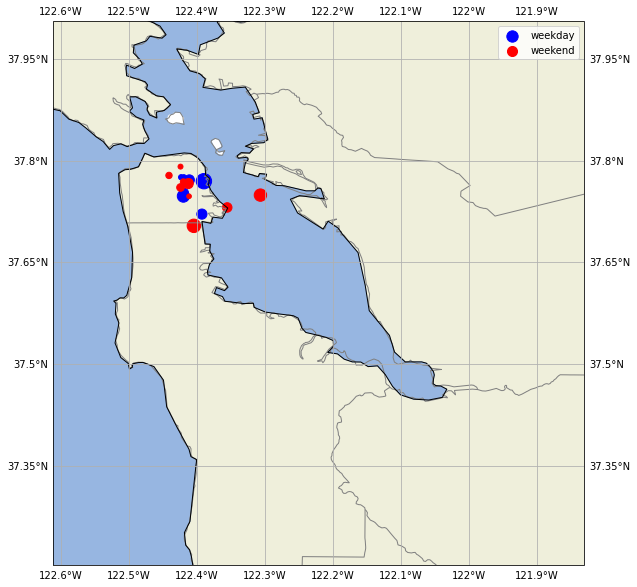

In [171]:
plt.figure(figsize=(16,10))
ax = plt.axes(projection=ccrs.PlateCarree())
y = [weekday_centers[:,1], weekend_centers[:,1]]
x = [weekday_centers[:,2], weekend_centers[:,2]]
s = [weekday_centers[:,0], weekend_centers[:,0], ]
extent = (minlon-.1, maxlon+.1, minlat-.1, maxlat+.1)


# plot ocean, land, lakes
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.add_feature(cfeature.OCEAN.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

# plot coastline and lat-lon gridlines
gl = ax.gridlines(draw_labels=True)
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.set_extent(extent)

# plot entire SF bay area pickup dropoff locations 
# with the scale of the circle representing payment
ax.scatter(x[0], y[0], s = s[0]*5,  color = 'b', )#facecolors='none')
ax.scatter(x[1], y[1], s = s[1]*5, color = 'r', )#facecolors='none')
ax.legend(['weekday','weekend'])

The recommended pickup locations with higher price (larger dots) for the driver are located in the outskirts of SF downtown, as opposed to the downtown area during the weekdays. Notice that the forced clustering have brought one of the points to the ocean during the weekend, but it should just be representing the Oakland area for pickups.

Zoom into the dots with time labeled we'll get

[array([ 8.89516129, 14.21100917, 19.00943396,  8.41666667, 17.84313725,
        8.90243902, 15.89473684,  9.07692308, 12.27272727, 10.        ]), array([ 8.70967742, 15.04761905, 20.28571429,  6.        , 12.5625    ,
        6.55555556, 16.85714286,  7.77777778, 15.5       ,  6.5       ])]


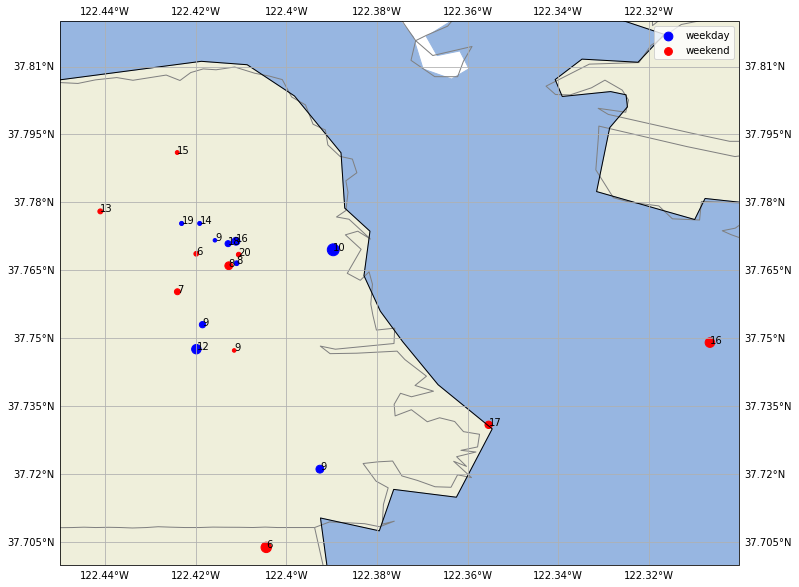

In [200]:
plt.figure(figsize=(16,10))
ax = plt.axes(projection=ccrs.PlateCarree())
y = [weekday_centers[:,1], weekend_centers[:,1]]
x = [weekday_centers[:,2], weekend_centers[:,2]]
s = [weekday_centers[:,0], weekend_centers[:,0], ]
times = [weekday_centers[:,3], weekend_centers[:,3], ]
print(times)
extent = (-122.45, -122.3, 37.7, 37.82)


# plot ocean, land, lakes
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.add_feature(cfeature.OCEAN.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

# plot coastline and lat-lon gridlines
gl = ax.gridlines(draw_labels=True)
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.set_extent(extent)

# plot entire SF bay area pickup dropoff locations 
# with the scale of the circle representing payment
for i, c in zip(range(2),('b','r')):
    ax.scatter(x[i], y[i], s = s[i]*3,  color = c, )#facecolors='none')
    for j, t in enumerate(times[i]):
        ax.annotate(str(round(t)), (x[i][j], y[i][j]), color='k')
#ax.scatter(x[1], y[1], s = s[1]*5, color = 'r', )#facecolors='none')
ax.legend(['weekday','weekend'])

There are three informations in this figure. The two colors represents weekend (blue) and weekday (red). The size of dots scales with the payment, e.g., bigger dots are associated with more payments. The time rounded to integers and annotated next to the dots. 

### Weekdays (blue)
The higher payments pickup locations are 9, 10am, 12pm scattered on the outskirts. Lower payments pickup locations are 8, 9am, 14, 16, 18, 19pm in the downtown area. 

Despite getting paid lower during evening after work, the driver should still focus on downtown SF since outskirts don't have much dots during those times. Drivers should definitely focus on the outskirts in the morning time.

### Weekends (red)
The higher payments are 6am, 16, 17pm scattered on the outskirts and 7, 8am in the downtown. So likely party goers entering late into downtown and tourists waking up early to explore the city. 

The lower payments are 6am, 13, 15, 20pm in the downtown where people are generally staying active walking around the city instead of using Uber.

# Summary
- Stay close to SF downtown any time. SF downtown has the highest density of pickups. 
- Best time recommendation of any location is rush hour times (7-9am, 16-19pm).
- Weekends SF area are generally low on pickups, so if the driver is desperate, maybe focus on the highest yield times (4-6am) and take a break for the weekend.
- Weekdays and weekends stategies:
  - During weekdays, stay close to SF downtown.
  - During weekends, stay close to outskirt of SF downtown around 6am, 16, 17pm, and SF downtown for other times. 

Otherthings to keep in mind:
- The commission from Uber barely changes from 20\%. 
